Importação das funções auxiliares e bibliotecas de aprendizado de máquina utilizados.

In [237]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier



from copy import deepcopy
from itertools import count
import random
from matplotlib.pyplot import axis
from sklearn.utils import shuffle
from math import ceil
import pandas as pd

def printa(a):
    print(a)
    return

def normalizaMinMax(coluna):
    minimo = coluna.min()
    maximo = coluna.max()
    return (coluna-minimo)/(maximo-minimo)

def split_in_folds(data, k):
    max_fold_size = ceil(data["id"].count()/k)
    folds = []
    for fold_index in range(k):
        folds.append([])
        for item_index in range(max_fold_size):
            item = data.sample()
            data.drop(item.index, inplace=True)
            folds[fold_index].append(item)
            if data.empty:
                break
    return folds

def merge_folds(folds):
    result = []
    for fold in folds:
        result += fold
    return result

def fold_to_df(fold):
    df = fold[0]
    for item_index in range(1, len(fold)):
        df = pd.concat([df, fold[item_index]])
    return df

def k_fold(data, k=5):
    data_clone = deepcopy(data)
    folds = split_in_folds(data_clone, k)
    fold_sets = []
    for fold_index, fold in enumerate(folds):
        test_fold = fold_to_df(fold)
        training_folds = deepcopy(folds)
        training_folds = training_folds[:fold_index]+training_folds[fold_index+1:]
        training_folds = merge_folds(training_folds)
        training_folds = fold_to_df(training_folds)
        fold_sets.append({'training_data': training_folds, 'test_data': test_fold})
    return fold_sets

def split_validation_df(data, percentage=0.1):
    model_df = deepcopy(data)
    validation_size = int(model_df["id"].count()*percentage)
    item = model_df.sample()
    validation_df = item
    model_df.drop(item.index, inplace=True)
    for item_index in range(1, validation_size):
        item = model_df.sample()
        validation_df = pd.concat([validation_df, item])
        model_df.drop(item.index, inplace=True)
    return validation_df, model_df

def get_confusion_matrix(tp, fn, fp, tn):
    return {'tp':tp, 'fn':fn, 'fp':fp, 'tn':tn}

def get_sensitivity(confusion_matrix):
    return confusion_matrix['tp']/(confusion_matrix['tp']+confusion_matrix['fn'])

def fix_undersampling(data, feature, under_value=1,proportion=1.0):
    apenas_under = data.where(data[feature] == under_value).dropna(how='all')
    apenas_not_under = data.where(data[feature] != under_value).dropna(how='all')
    under_count = int(apenas_under["id"].count()*proportion)
    print("under count: " + str(under_count))

    print(apenas_under.count())
    print(apenas_not_under.count())
    item = apenas_not_under.sample()
    apenas_not_under.drop(item.index, inplace=True)
    dados = item
    for i in range(1, under_count):
        item = apenas_not_under.sample()
        apenas_not_under.drop(item.index, inplace=True)
        dados = pd.concat([dados,item])
    dados = pd.concat([dados, apenas_under])
    return dados

def get_confusion_matrix(results:list, expected:list):
    tp = fn = fp = tn = 0
    for index, result in enumerate(results):
        if result == 1 and expected[index] == 1:
            tp += 1
        elif result == 0 and expected[index] == 0:
            tn += 1
        elif result == 1 and expected[index] == 0:
            fp += 1
        elif result == 0 and expected[index] == 1:
            fn += 1
    return {'tp':tp, 'fn':fn, 'fp':fp, 'tn':tn}

def get_recall(confusion_matrix):
    return confusion_matrix['tp']/(confusion_matrix['tp']+confusion_matrix['fn'])

def get_precision(confusion_matrix):
    return confusion_matrix['tp']/(confusion_matrix['tp']+confusion_matrix['fp'])

def get_accuracy(confusion_matrix):
    return (confusion_matrix['tp']+confusion_matrix['tn'])/(confusion_matrix['tp']+confusion_matrix['tn']+confusion_matrix['fp']+confusion_matrix['fn'])

def get_f1_score(confusion_matrix):
    return (2*confusion_matrix['tp'])/(2*confusion_matrix['tp']+confusion_matrix['fp']+confusion_matrix['fn'])




Importação dos dados

In [229]:
dados_entrada = pd.read_csv("healthcare-dataset-stroke-data.csv")
dados_entrada.head(20)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [230]:
dados_entrada = pd.read_csv("healthcare-dataset-stroke-data.csv")

dummies = pd.get_dummies(dados_entrada["gender"], prefix="gender-")
dados_pos_dummies = dados_entrada.join(dummies)

dummies = pd.get_dummies(dados_entrada["smoking_status"],prefix = "smoking_status-")
dados_pos_dummies = dados_pos_dummies.join(dummies)

dummies = pd.get_dummies(dados_entrada["Residence_type"],prefix = "Residence_type-")
dados_pos_dummies = dados_pos_dummies.join(dummies)

dummies = pd.get_dummies(dados_entrada["work_type"],prefix = "work_type-")
dados_pos_dummies = dados_pos_dummies.join(dummies)

dummies = pd.get_dummies(dados_entrada["ever_married"],prefix = "ever_married-")
dados_pos_dummies = dados_pos_dummies.join(dummies)

dados_pos_dummies.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,...,smoking_status-_smokes,Residence_type-_Rural,Residence_type-_Urban,work_type-_Govt_job,work_type-_Never_worked,work_type-_Private,work_type-_Self-employed,work_type-_children,ever_married-_No,ever_married-_Yes
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,...,0,0,1,0,0,1,0,0,0,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,...,0,1,0,0,0,0,1,0,0,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,...,0,1,0,0,0,1,0,0,0,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,...,1,0,1,0,0,1,0,0,0,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,...,0,1,0,0,0,0,1,0,0,1


In [231]:
dados_pos_dummies_dropna = dados_pos_dummies.dropna(axis=1)
dados_pos_dummies_dropna.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,stroke,gender-_Female,gender-_Male,gender-_Other,smoking_status-_Unknown,...,smoking_status-_smokes,Residence_type-_Rural,Residence_type-_Urban,work_type-_Govt_job,work_type-_Never_worked,work_type-_Private,work_type-_Self-employed,work_type-_children,ever_married-_No,ever_married-_Yes
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,...,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,0.048728,0.585910,0.413894,0.000196,0.302153,...,0.154403,0.491977,0.508023,0.128571,0.004305,0.572407,0.160274,0.134442,0.343836,0.656164
std,21161.721625,22.612647,0.296607,0.226063,45.283560,0.215320,0.492612,0.492578,0.013989,0.459236,...,0.361370,0.499985,0.499985,0.334758,0.065480,0.494778,0.366896,0.341160,0.475034,0.475034
min,67.000000,0.080000,0.000000,0.000000,55.120000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,0.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [232]:
features = dados_pos_dummies_dropna.columns
lista_features = features.to_list()
lista_features.remove("id")
lista_features.remove("gender")
lista_features.remove("ever_married")
lista_features.remove("work_type")
lista_features.remove("Residence_type")
lista_features.remove("smoking_status")
lista_features.remove("stroke")
lista_features

['age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'gender-_Female',
 'gender-_Male',
 'gender-_Other',
 'smoking_status-_Unknown',
 'smoking_status-_formerly smoked',
 'smoking_status-_never smoked',
 'smoking_status-_smokes',
 'Residence_type-_Rural',
 'Residence_type-_Urban',
 'work_type-_Govt_job',
 'work_type-_Never_worked',
 'work_type-_Private',
 'work_type-_Self-employed',
 'work_type-_children',
 'ever_married-_No',
 'ever_married-_Yes']

Normalização os dados

In [233]:
dados_normalizados = dados_pos_dummies_dropna.copy(deep = True)

for feature in lista_features:
    dados_normalizados[feature] = normalizaMinMax(dados_normalizados[feature])

dados_normalizados.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,...,smoking_status-_smokes,Residence_type-_Rural,Residence_type-_Urban,work_type-_Govt_job,work_type-_Never_worked,work_type-_Private,work_type-_Self-employed,work_type-_children,ever_married-_No,ever_married-_Yes
0,9046,Male,0.816895,0.0,1.0,Yes,Private,Urban,0.801265,formerly smoked,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,51676,Female,0.743652,0.0,0.0,Yes,Self-employed,Rural,0.679023,never smoked,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,31112,Male,0.975586,0.0,1.0,Yes,Private,Rural,0.234512,never smoked,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,60182,Female,0.597168,0.0,0.0,Yes,Private,Urban,0.536008,smokes,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1665,Female,0.963379,1.0,0.0,Yes,Self-employed,Rural,0.549349,never smoked,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Existem muitas instancias de teste que não são positivas para stroke, o dataset está desbalanceado, para mitigar esse vies do modelo, o balanceamento do dataset é feito através do undersampling.

In [220]:
dados_undersampling = fix_undersampling(dados_normalizados,"stroke",1,1)
dados_undersampling.count()

under count: 249
id                                 249
gender                             249
age                                249
hypertension                       249
heart_disease                      249
ever_married                       249
work_type                          249
Residence_type                     249
avg_glucose_level                  249
smoking_status                     249
stroke                             249
gender-_Female                     249
gender-_Male                       249
gender-_Other                      249
smoking_status-_Unknown            249
smoking_status-_formerly smoked    249
smoking_status-_never smoked       249
smoking_status-_smokes             249
Residence_type-_Rural              249
Residence_type-_Urban              249
work_type-_Govt_job                249
work_type-_Never_worked            249
work_type-_Private                 249
work_type-_Self-employed           249
work_type-_children                249
ever_mar

id                                 498
gender                             498
age                                498
hypertension                       498
heart_disease                      498
ever_married                       498
work_type                          498
Residence_type                     498
avg_glucose_level                  498
smoking_status                     498
stroke                             498
gender-_Female                     498
gender-_Male                       498
gender-_Other                      498
smoking_status-_Unknown            498
smoking_status-_formerly smoked    498
smoking_status-_never smoked       498
smoking_status-_smokes             498
Residence_type-_Rural              498
Residence_type-_Urban              498
work_type-_Govt_job                498
work_type-_Never_worked            498
work_type-_Private                 498
work_type-_Self-employed           498
work_type-_children                498
ever_married-_No         

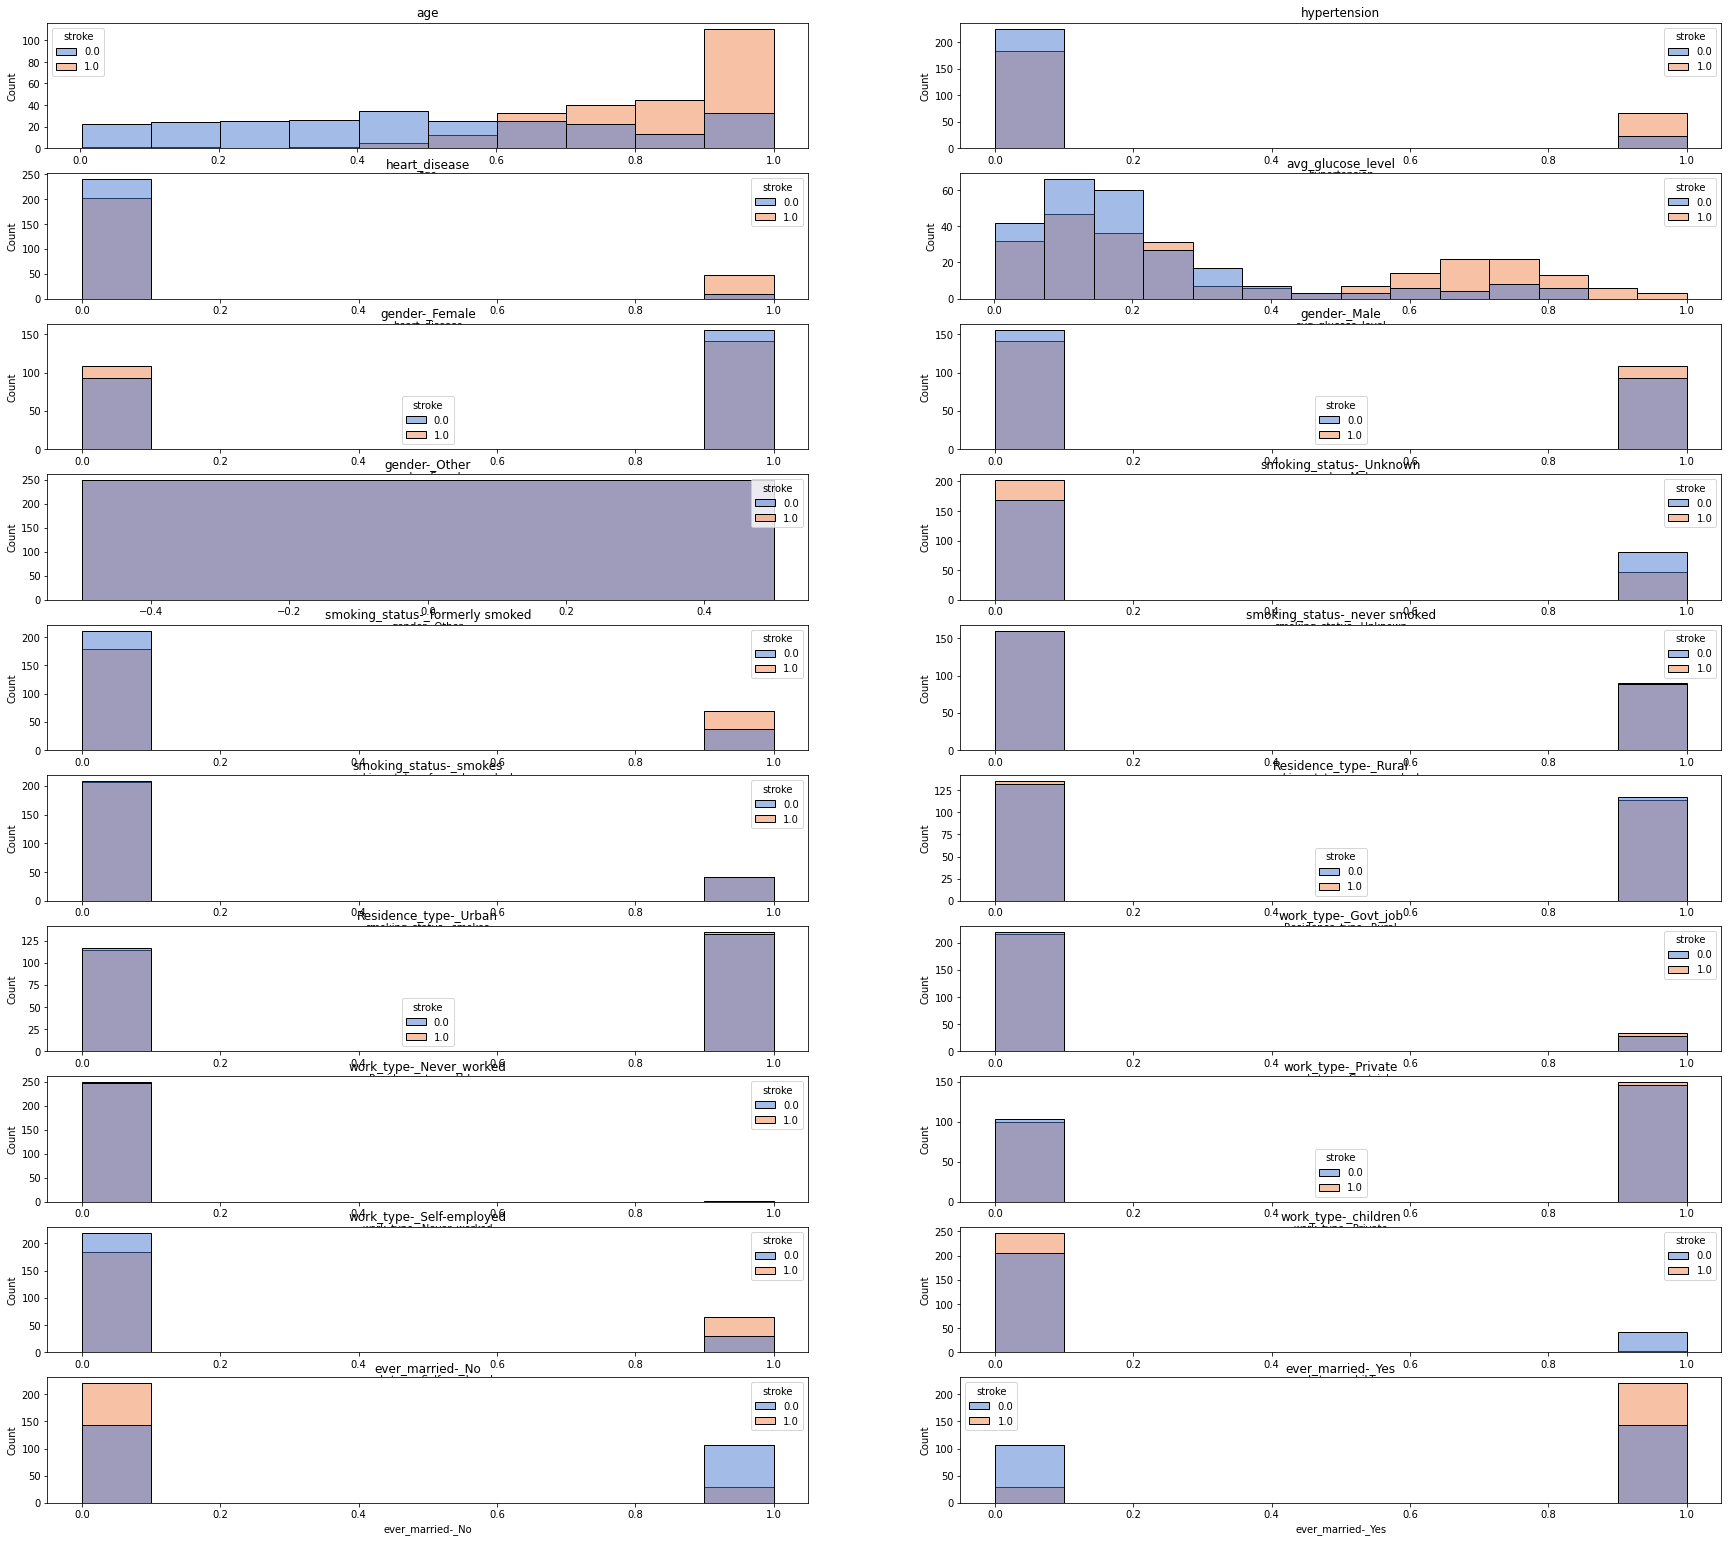

In [235]:
i = 0
his = plt.gcf()
his.set_size_inches(30, 30)
for feature in lista_features:
    i = i+1
    plt.subplot(11,2,i)
    sns.histplot(data = dados_undersampling,x = feature, hue="stroke", palette="muted").set_title(feature)

Separar o conjunto de validação

In [236]:
validacao_df, modelo_df = split_validation_df(dados_undersampling,0.2)
validacao_df.head

<bound method NDFrame.head of            id  gender       age  hypertension  heart_disease ever_married  \
186   16077.0    Male  0.768066           0.0            1.0          Yes   
1431  32459.0  Female  0.926758           0.0            0.0          Yes   
175   14431.0    Male  0.877930           1.0            0.0          Yes   
222   12689.0  Female  0.768066           0.0            0.0          Yes   
982   54747.0    Male  0.009766           0.0            0.0           No   
...       ...     ...       ...           ...            ...          ...   
31    33879.0    Male  0.511719           0.0            0.0          Yes   
27    61843.0    Male  0.707031           0.0            0.0          Yes   
128   37132.0    Male  1.000000           0.0            0.0          Yes   
3268  24074.0  Female  0.023438           0.0            0.0           No   
201   68627.0    Male  0.975586           1.0            1.0          Yes   

          work_type Residence_type  avg_gluco

K-Nearest Neighbors Classifier

In [240]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score


knn = KNeighborsClassifier(n_neighbors=1)

TOTAL_FOLDS = 4
fold_sets = k_fold(modelo_df, TOTAL_FOLDS)
acuracia = 0
precisao = 0
recall = 0
f1 =0

matriz_confusao = []
for fold_set in fold_sets:
    treino_df = fold_set["training_data"]
    teste_df = fold_set["test_data"]

    Xtreino = treino_df[lista_features]
    ytreino = treino_df["stroke"]
    knn.fit(Xtreino,ytreino)

    Xteste = teste_df[lista_features]
    yteste = teste_df["stroke"]
    ypredito = knn.predict(Xteste)
    matriz_confusao = get_confusion_matrix(list(ypredito),list(yteste))
    print(get_accuracy(matriz_confusao))
    acuracia = acuracia + get_accuracy(matriz_confusao)
    recall = recall+get_recall(matriz_confusao)
    precisao = precisao+get_precision(matriz_confusao)
    f1 = f1+get_f1_score(matriz_confusao)


print("Acuracia média: " + (str(acuracia/TOTAL_FOLDS)))
print("Precisão médio: " + (str(precisao/TOTAL_FOLDS)))
print("Recall médio: " + (str(recall/TOTAL_FOLDS)))
print("F1 médio: " + (str(f1/TOTAL_FOLDS)))


Acuracia média: 0.6492424242424242
Precisão médio: 0.6598466981132075
Recall médio: 0.6489178690344062
F1 médio: 0.6516950405090566


Arvores de decisão

In [223]:
from sklearn.tree import DecisionTreeClassifier

dts = DecisionTreeClassifier()

TOTAL_FOLDS = 6
fold_sets = k_fold(modelo_df, TOTAL_FOLDS)
score = 0
accuracy = 0

for fold_set in fold_sets:
    treino_df = fold_set["training_data"]
    teste_df = fold_set["test_data"]

    Xtreino = treino_df[lista_features]
    ytreino = treino_df["stroke"]
    dts.fit(Xtreino,ytreino)

    Xteste = teste_df[lista_features]
    yteste = teste_df["stroke"]
    y_result = dts.predict(Xteste)
    print(precision_score(y_result,yteste))
    accuracy = accuracy + accuracy_score(y_result,yteste)
    score = score + precision_score(y_result,yteste)

print("Acc média: " + str(accuracy/TOTAL_FOLDS))
print("Precision média: " + (str(score/TOTAL_FOLDS)))

0.7575757575757576
0.8181818181818182
0.631578947368421
0.7333333333333333
0.75
0.7714285714285715
Acc média: 0.7370569029850746
Precision média: 0.7436830713146502


Floresta de decisão

In [224]:
rfc = RandomForestClassifier()

TOTAL_FOLDS = 6
fold_sets = k_fold(modelo_df, TOTAL_FOLDS)
score = 0
accuracy = 0

for fold_set in fold_sets:
    treino_df = fold_set["training_data"]
    teste_df = fold_set["test_data"]

    Xtreino = treino_df[lista_features]
    ytreino = treino_df["stroke"]
    rfc.fit(Xtreino,ytreino)

    Xteste = teste_df[lista_features]
    yteste = teste_df["stroke"]
    y_result = rfc.predict(Xteste)
    print(precision_score(y_result,yteste))
    accuracy = accuracy + accuracy_score(y_result,yteste)
    score = score + precision_score(y_result,yteste)

print("Acc média: " + str(accuracy/TOTAL_FOLDS))
print("Precision média: " + (str(score/TOTAL_FOLDS)))

0.7777777777777778
0.7222222222222222
0.8484848484848485
0.8823529411764706
0.7837837837837838
0.7241379310344828
Acc média: 0.7365904850746269
Precision média: 0.7897932507465977


Adaptive Boosting

In [225]:
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier()

TOTAL_FOLDS = 4
fold_sets = k_fold(modelo_df, TOTAL_FOLDS)
score = 0
accuracy = 0

for fold_set in fold_sets:
    treino_df = fold_set["training_data"]
    teste_df = fold_set["test_data"]

    Xtreino = treino_df[lista_features]
    ytreino = treino_df["stroke"]
    adb.fit(Xtreino,ytreino)

    Xteste = teste_df[lista_features]
    yteste = teste_df["stroke"]
    y_predito = adb.predict(Xteste)
    print(precision_score(y_predito,yteste))
    accuracy = accuracy + accuracy_score(y_predito,yteste)
    score = score + precision_score(y_predito,yteste)

print("Acc média: " + str(accuracy/TOTAL_FOLDS))
print("Precision média: " + (str(score/TOTAL_FOLDS)))

0.8301886792452831
0.7272727272727273
0.9130434782608695
0.8627450980392157
Acc média: 0.7417676767676767
Precision média: 0.8333124957045239
[0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.
 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 0. 1.]
94      1.0
5091    0.0
26      1.0
191     1.0
819     0.0
       ... 
2669    0.0
161     1.0
146     1.0
4230    0.0
41      1.0
Name: stroke, Length: 99, dtype: float64


Rede Neural

In [226]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(warm_start=True, max_iter =400)

TOTAL_FOLDS = 6
fold_sets = k_fold(modelo_df, TOTAL_FOLDS)
score = 0
accuracy = 0

for fold_set in fold_sets:
    treino_df = fold_set["training_data"]
    teste_df = fold_set["test_data"]

    Xtreino = treino_df[lista_features]
    ytreino = treino_df["stroke"]
    MLP.fit(Xtreino,ytreino)

    Xteste = teste_df[lista_features]
    yteste = teste_df["stroke"]
    y_result = MLP.predict(Xteste)
    print(precision_score(y_result,yteste))
    accuracy = accuracy + accuracy_score(y_result,yteste)
    score = score + precision_score(y_result,yteste)

print("Acc média: " + str(accuracy/TOTAL_FOLDS))
print("Precision média: " + (str(score/TOTAL_FOLDS)))


0.7631578947368421
0.7692307692307693
0.8888888888888888
0.9
0.8125
1.0
Acc média: 0.8450715174129354
Precision média: 0.85562959214275


C:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


In [227]:
from sklearn.ensemble import GradientBoostingClassifier

GDB = GradientBoostingClassifier()

TOTAL_FOLDS = 6
fold_sets = k_fold(modelo_df, TOTAL_FOLDS)
score = 0
accuracy = 0

for fold_set in fold_sets:
    treino_df = fold_set["training_data"]
    teste_df = fold_set["test_data"]

    Xtreino = treino_df[lista_features]
    ytreino = treino_df["stroke"]
    GDB.fit(Xtreino,ytreino)

    Xteste = teste_df[lista_features]
    yteste = teste_df["stroke"]
    y_result = GDB.predict(Xteste)
    print(precision_score(y_result,yteste))
    accuracy = accuracy + accuracy_score(y_result,yteste)
    score = score + precision_score(y_result,yteste)

print("Acc média: " + str(accuracy/TOTAL_FOLDS))
print("Precision média: " + (str(score/TOTAL_FOLDS)))

0.7352941176470589
0.9444444444444444
0.8484848484848485
0.8205128205128205
0.896551724137931
0.9411764705882353
Acc média: 0.7796952736318409
Precision média: 0.8644107376358899
